In [1]:
import xarray as xr
import glob
import numpy as np

import tensorflow as tf

from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [2]:
imp.reload(preprocessing)
imp.reload(experiment_settings)
imp.reload(build_model)
imp.reload(metricplots)
imp.reload(allthelinalg)
imp.reload(analysisplots)

<module 'analysisplots' from '/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/functions/analysisplots.py'>

In [3]:
modelpath = "models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
testvariants = experiment_dict["testvariants"]
seedlist = experiment_dict["seeds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+run

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
inres = experiment_dict["inres"]
transform = ccrs.PlateCarree()
obsyearvec_ERSST = np.arange(1854+3*run+leadtime,2024,)
obsyearvec_HadISST = np.arange(1870+3*run+leadtime,2024,)
modelyearvec = np.arange(year1+2*run+leadtime,2015)
latvec = np.arange(-90+inres/2,90+inres/2,inres)
lonvec = np.arange(0+inres/2,360+inres/2,inres)

weights = np.meshgrid(lon,lat)[1]
latweights = np.sqrt(np.cos(np.deg2rad(weights)))

In [4]:
datafile = "processed_data/" + filefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"]

trainvaltest = [trainvariants,valvariants,testvariants]

inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
    allinputdata,alloutputdata,trainvaltest,experiment_dict["run"])

inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0

outputstd = np.std(outputdata, axis=0, keepdims=True)
outputdata = outputdata/outputstd
outputval = outputval/outputstd
outputtest = outputtest/outputstd

outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0  

nvars = int(len(valvariants)*len(modellist))
nvariant = len(testvariants)
nvars_test = int(len(testvariants))*len(modellist)
nmodels = len(modellist)
ntimesteps = int(len(outputtest)/(nvariant*nmodels))
n1model = ntimesteps*nvariant

mask = np.copy(outputtest)
mask[mask==0] = np.nan
landmask = ~np.isnan(np.mean(mask,axis=0))
latweights[~landmask] = 0

conversion done


In [5]:
inputobs_ERSST,outputobs_ERSST = preprocessing.make_inputoutput_obs(experiment_dict,"ERSST")
inputobs_ERSST,outputobs_ERSST = preprocessing.concatobs(inputobs_ERSST,outputobs_ERSST,outputstd,run)

inputobs_HadISST,outputobs_HadISST = preprocessing.make_inputoutput_obs(experiment_dict,"HadISST")
inputobs_HadISST,outputobs_HadISST = preprocessing.concatobs(inputobs_HadISST,outputobs_HadISST,outputstd,run)

In [6]:
def reshapengrab(inputmatrix,ind,nmodels,nvariants):

    # grabs all variants (nvariant) for a single climate model data (ind of nmodel) 
    inputshape = inputmatrix.shape
    ntimesteps = int(inputshape[0]/(nmodels*nvariants))
    if len(inputshape) == 3:        
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    outputint = intmatrix[ind]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2],inputshape[3])
    outputmatrix = np.reshape(outputint,shapeout)    
    
    return outputmatrix

def model_member_corr(pattern,outputtest,y_pred_test,nmodels,nvariant,landmask):
    
    modelpearsons = np.empty((nmodels,nvariant))
    modelps = np.empty((nmodels,nvariant))
    
    #modelpearsonsall = np.empty((nmodels))

    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,landmask)
    
    return modelpearsons

def weightedMSE(y_pred,y_true,weights):
    err = ((y_pred-y_true)*weights)
    sqerr = err**2
    mse = np.mean(sqerr)
    return mse

In [7]:
domainMSE = []
SCMSE = []

for random_seed in seedlist:

    fileout = filename + "_seed=" + str(random_seed) +".h5"

    tf.random.set_seed(random_seed)
    np.random.seed(random_seed) 
    
    full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                    experiment_dict, random_seed)  
    
    full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                        loss=tf.keras.losses.MeanSquaredError(), 
                      )

    full_model.load_weights(fileout)
    
    full_model.trainable = False # freeze BN

    y_pred_val = full_model.predict(inputval) 
    
    bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   
    SCtimeseries_true = allthelinalg.index_timeseries(outputval,bestpattern,landmask)
    SCtimeseries_pred = allthelinalg.index_timeseries(y_pred_val,bestpattern,landmask)
    SCtimeseries_err = np.mean((SCtimeseries_true-SCtimeseries_pred)**2)
    
    mse = weightedMSE(y_pred_val,outputval,latweights)
    domainMSE.append(mse)
    SCMSE.append(mse)

domainMSE = np.asarray(domainMSE)
bestseed = np.argmin(domainMSE)


336/336 [==============================] - 1s 4ms/step


In [8]:
imp.reload(analysisplots)
random_seed = seedlist[bestseed]

fileout = filename + "_seed=" + str(random_seed) +".h5"

tf.random.set_seed(random_seed)
np.random.seed(random_seed) 

full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                experiment_dict, random_seed)  

full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                    loss=tf.keras.losses.MeanSquaredError(), 
                  )

full_model.load_weights(fileout)

full_model.trainable = False # freeze BN

y_pred_test = full_model.predict(inputtest)
y_pred_val = full_model.predict(inputval) 

bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   
# analysisplots.plotpattern_SST(bestpattern,lon,lat,outputstd,None)

336/336 [==============================] - 1s 4ms/step


/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


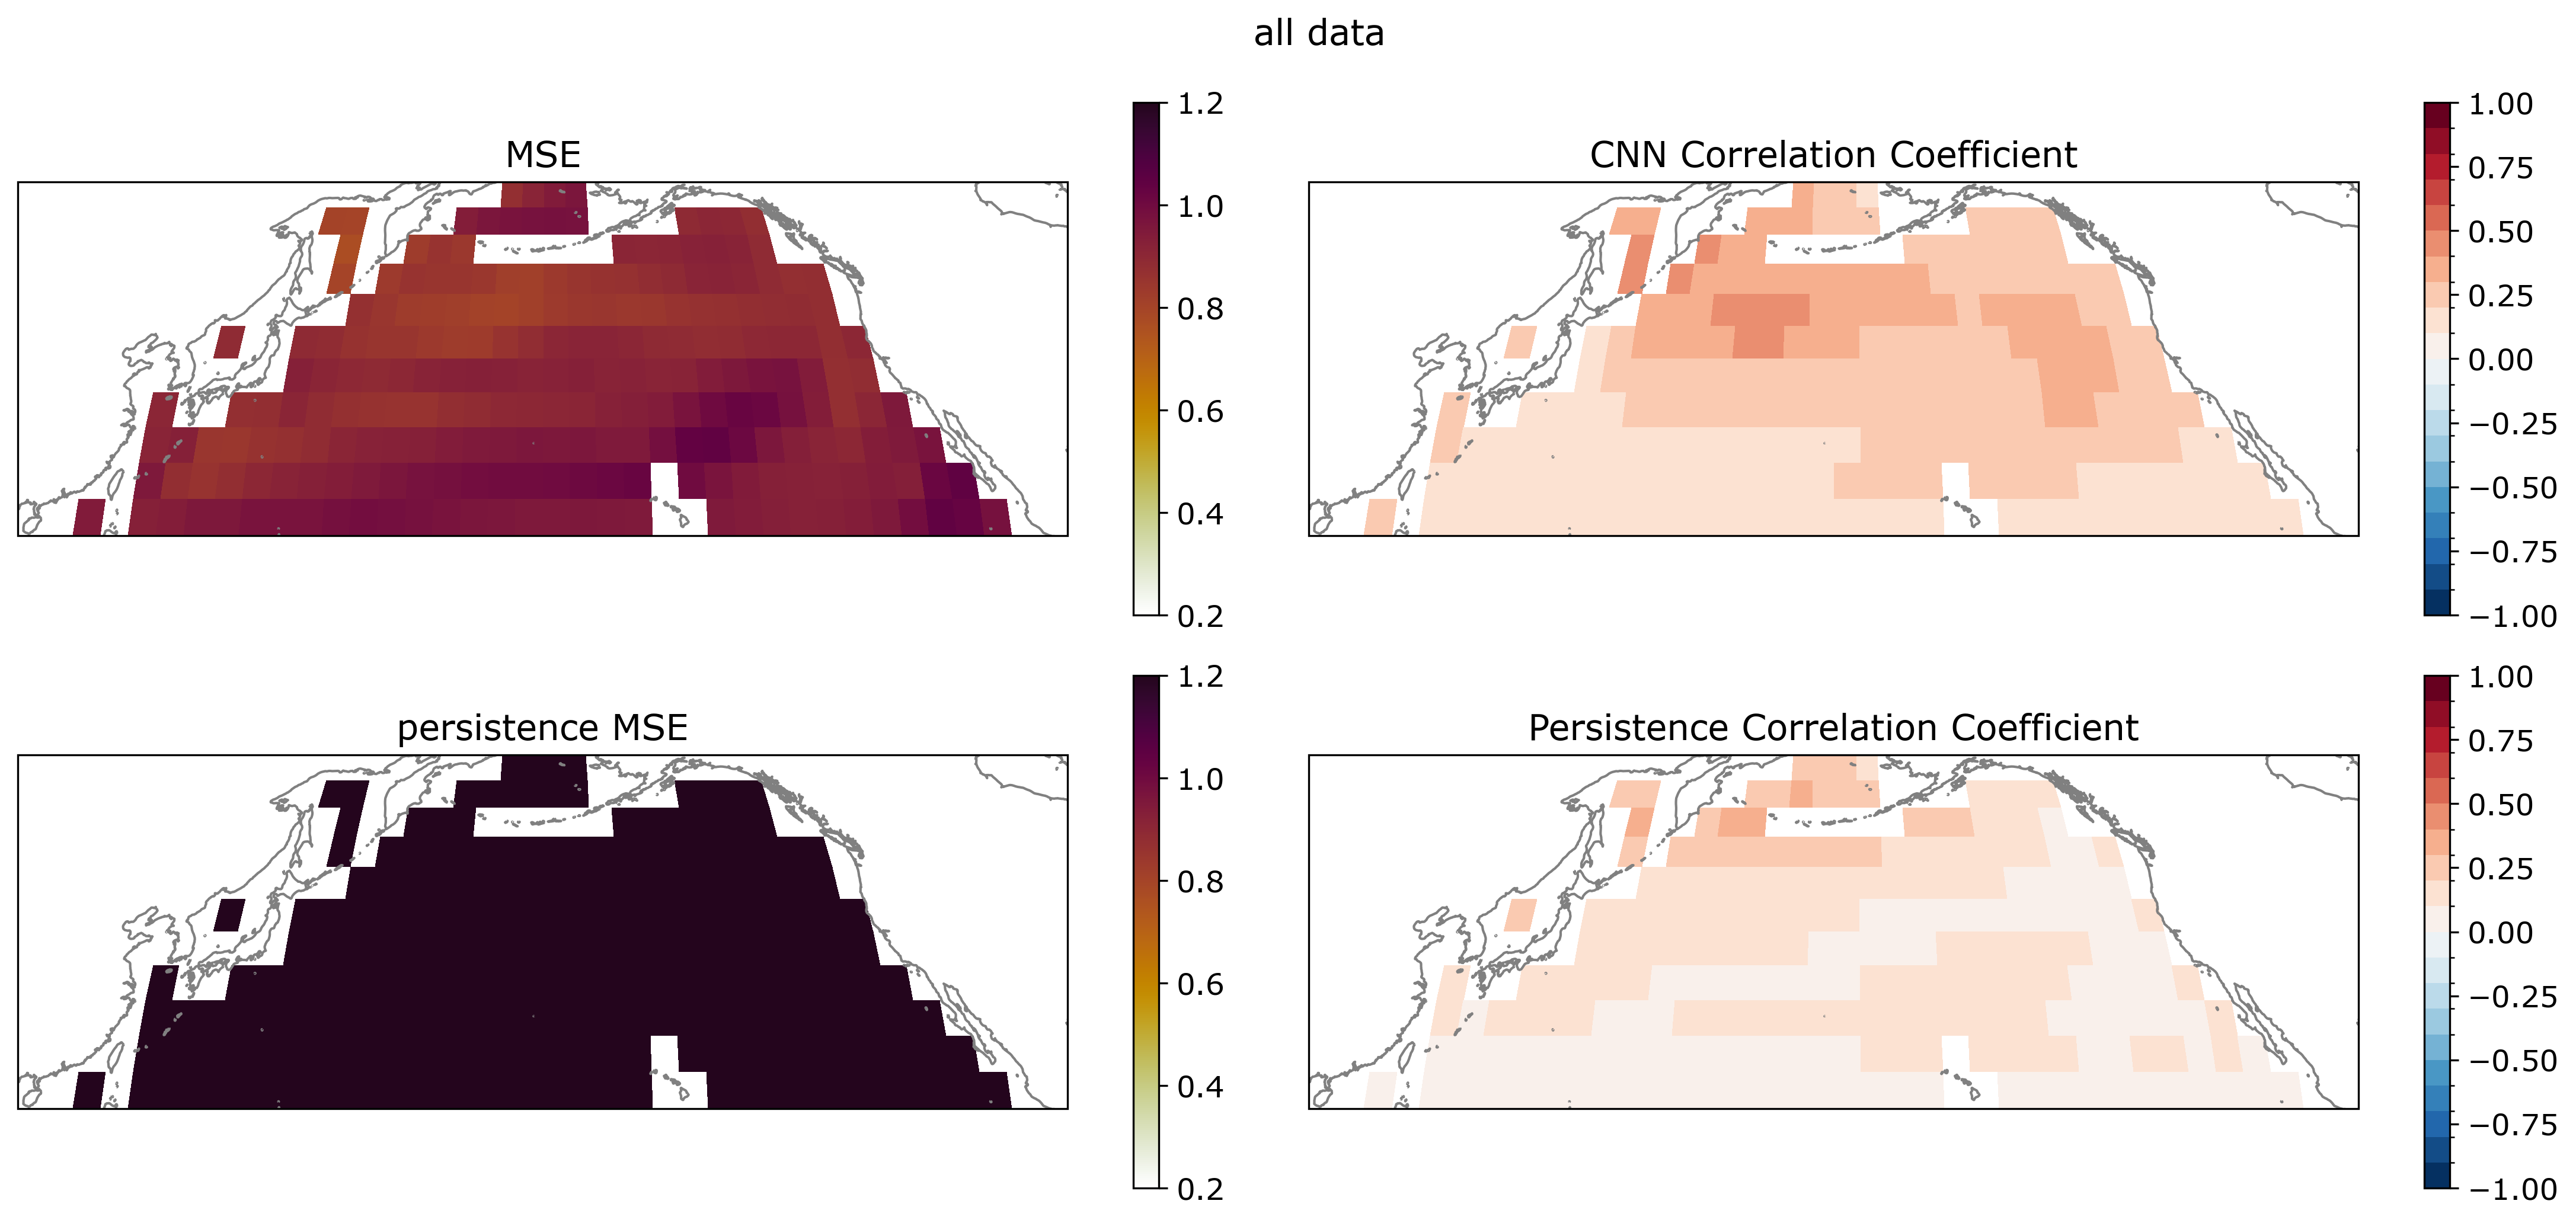

In [9]:
imp.reload(metricplots)
metricplots.mapps(y_pred_test,outputtest,nvars_test,lon,lat,centre,"all data",experiment_dict)

5/5 [==============================] - 0s 4ms/step


/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


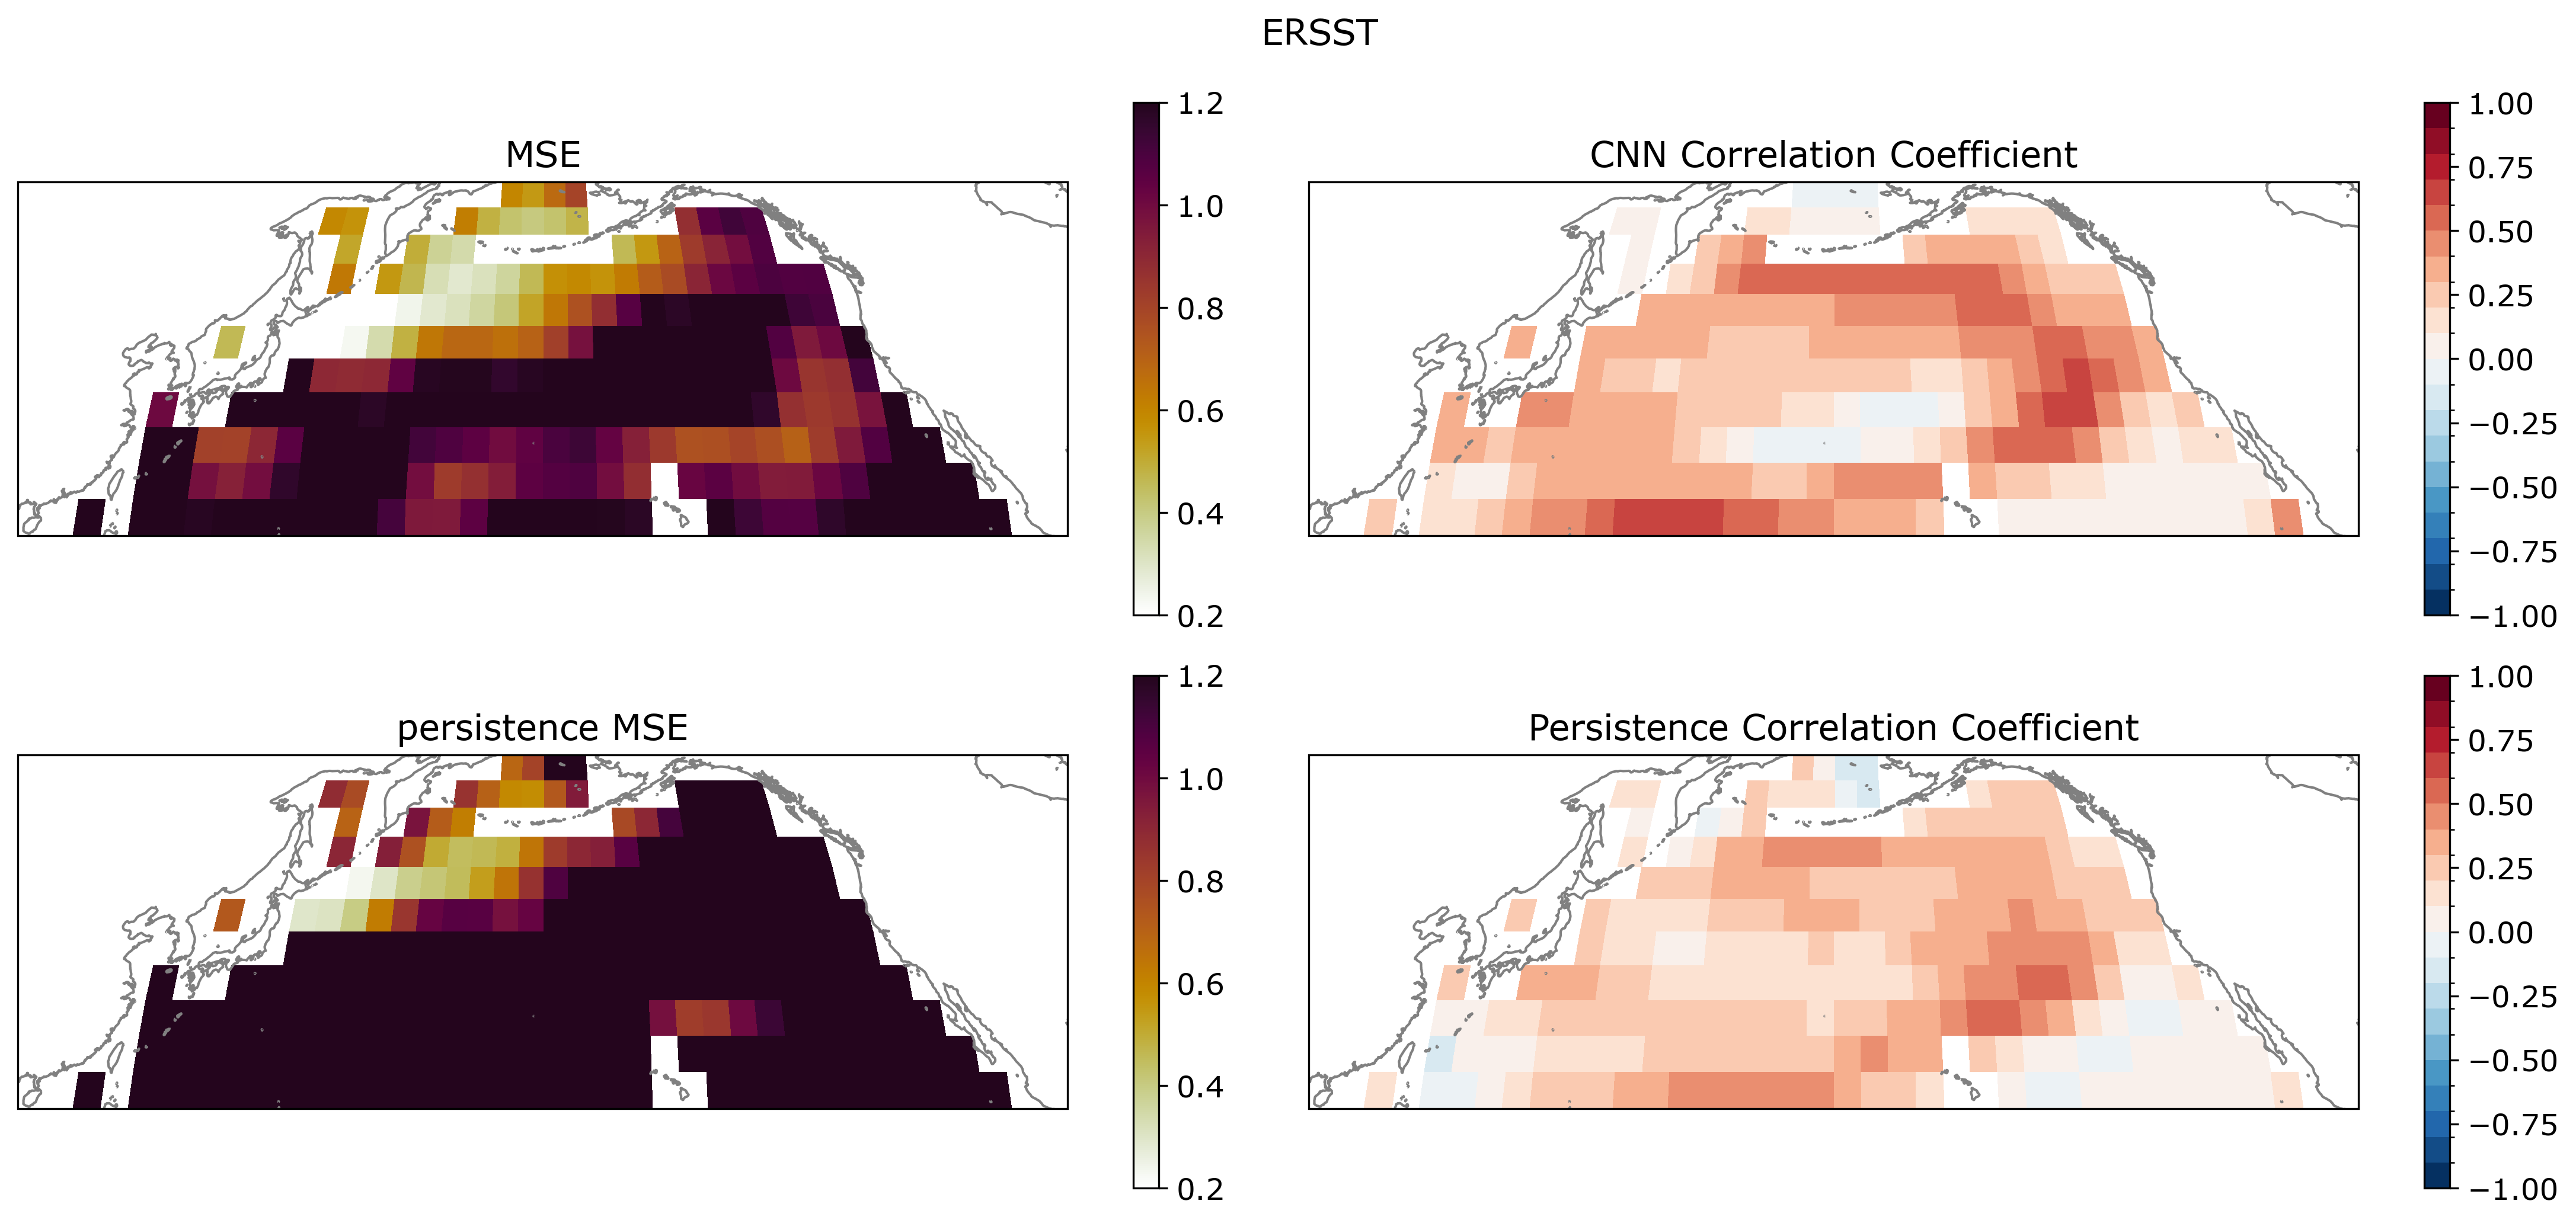

In [10]:
imp.reload(metricplots)

y_pred_obs = full_model.predict(inputobs_ERSST)

metricplots.mapps(y_pred_obs,outputobs_ERSST,1,lon,lat,centre,"ERSST",experiment_dict)

/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/egordon4/mambaforge/envs/tensorflow-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Use

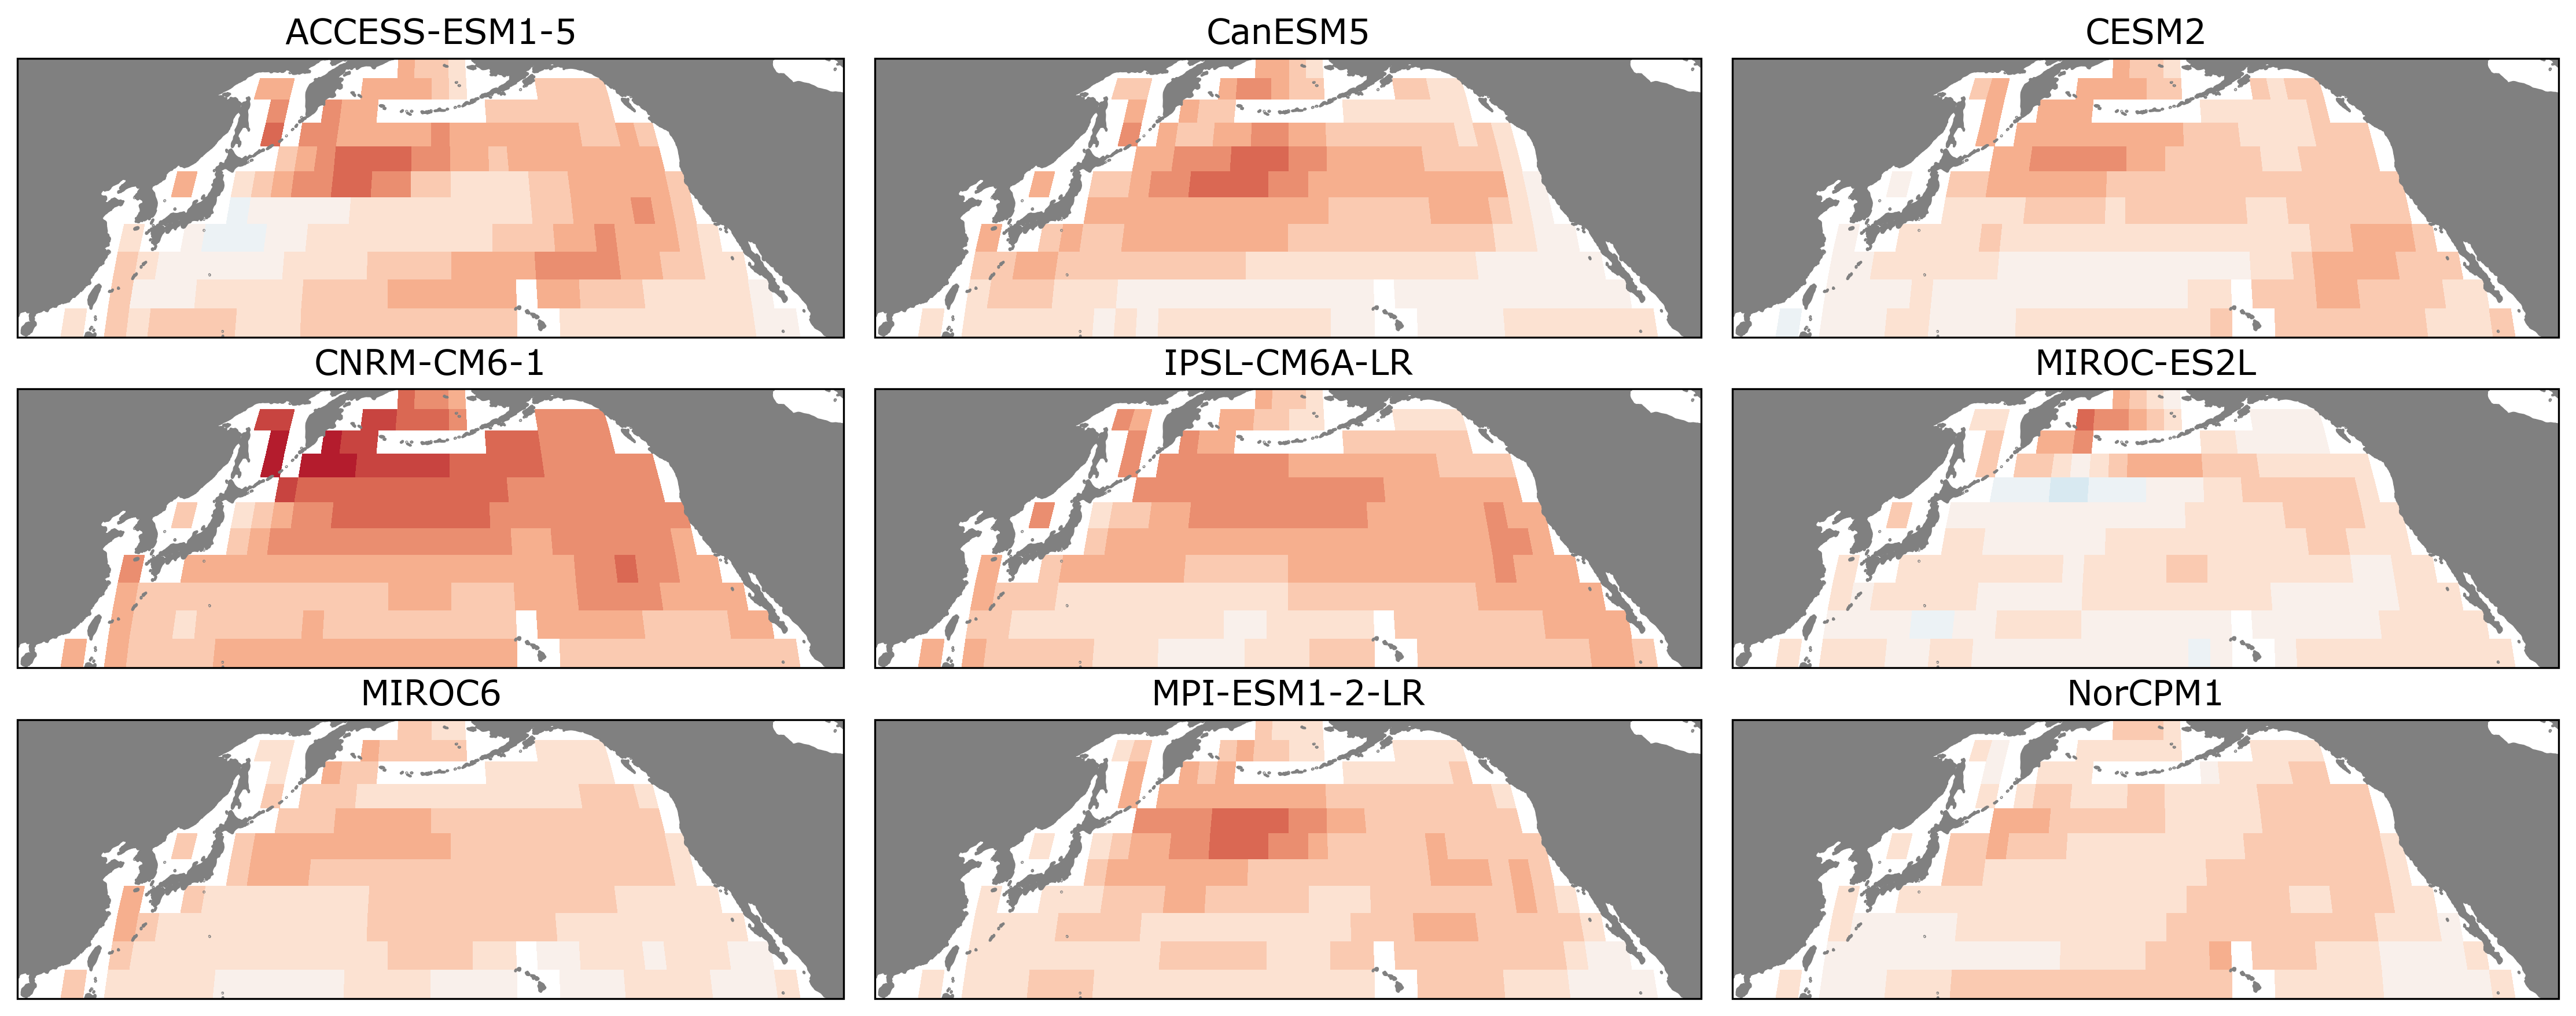

In [11]:
lbound = -1
ubound = 1

cmapdiv = plt.get_cmap("RdBu_r")
bounds = np.arange(lbound,ubound+0.1,0.1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmapdiv.N)
norm2 = colors.BoundaryNorm(boundaries=np.arange(-0.5,0.55,0.05), ncolors=cmapdiv.N)

plt.figure(figsize=(15,6))

for imodel,cmodel in enumerate(modellist):

    y_pred_test_loop = reshapengrab(y_pred_test,imodel,9,7)
    y_true_test_loop = reshapengrab(outputtest,imodel,9,7)

    ploop,mse = metricplots.metrics(y_pred_test_loop,y_true_test_loop)

    a0=plt.subplot(3,3,imodel+1,projection=projection)
    a0.pcolormesh(lon,lat,ploop,norm=norm,transform=transform,cmap="RdBu_r")
    a0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor="gray"))
    plt.title(cmodel)

plt.tight_layout()
plt.savefig("figures/allmodel_p.png",dpi=300)


In [12]:
ERSSTtseries = allthelinalg.index_timeseries(outputobs_ERSST,bestpattern,landmask)
ERSSTpattern = np.mean(ERSSTtseries[:,np.newaxis,np.newaxis]*outputobs_ERSST,axis=0)

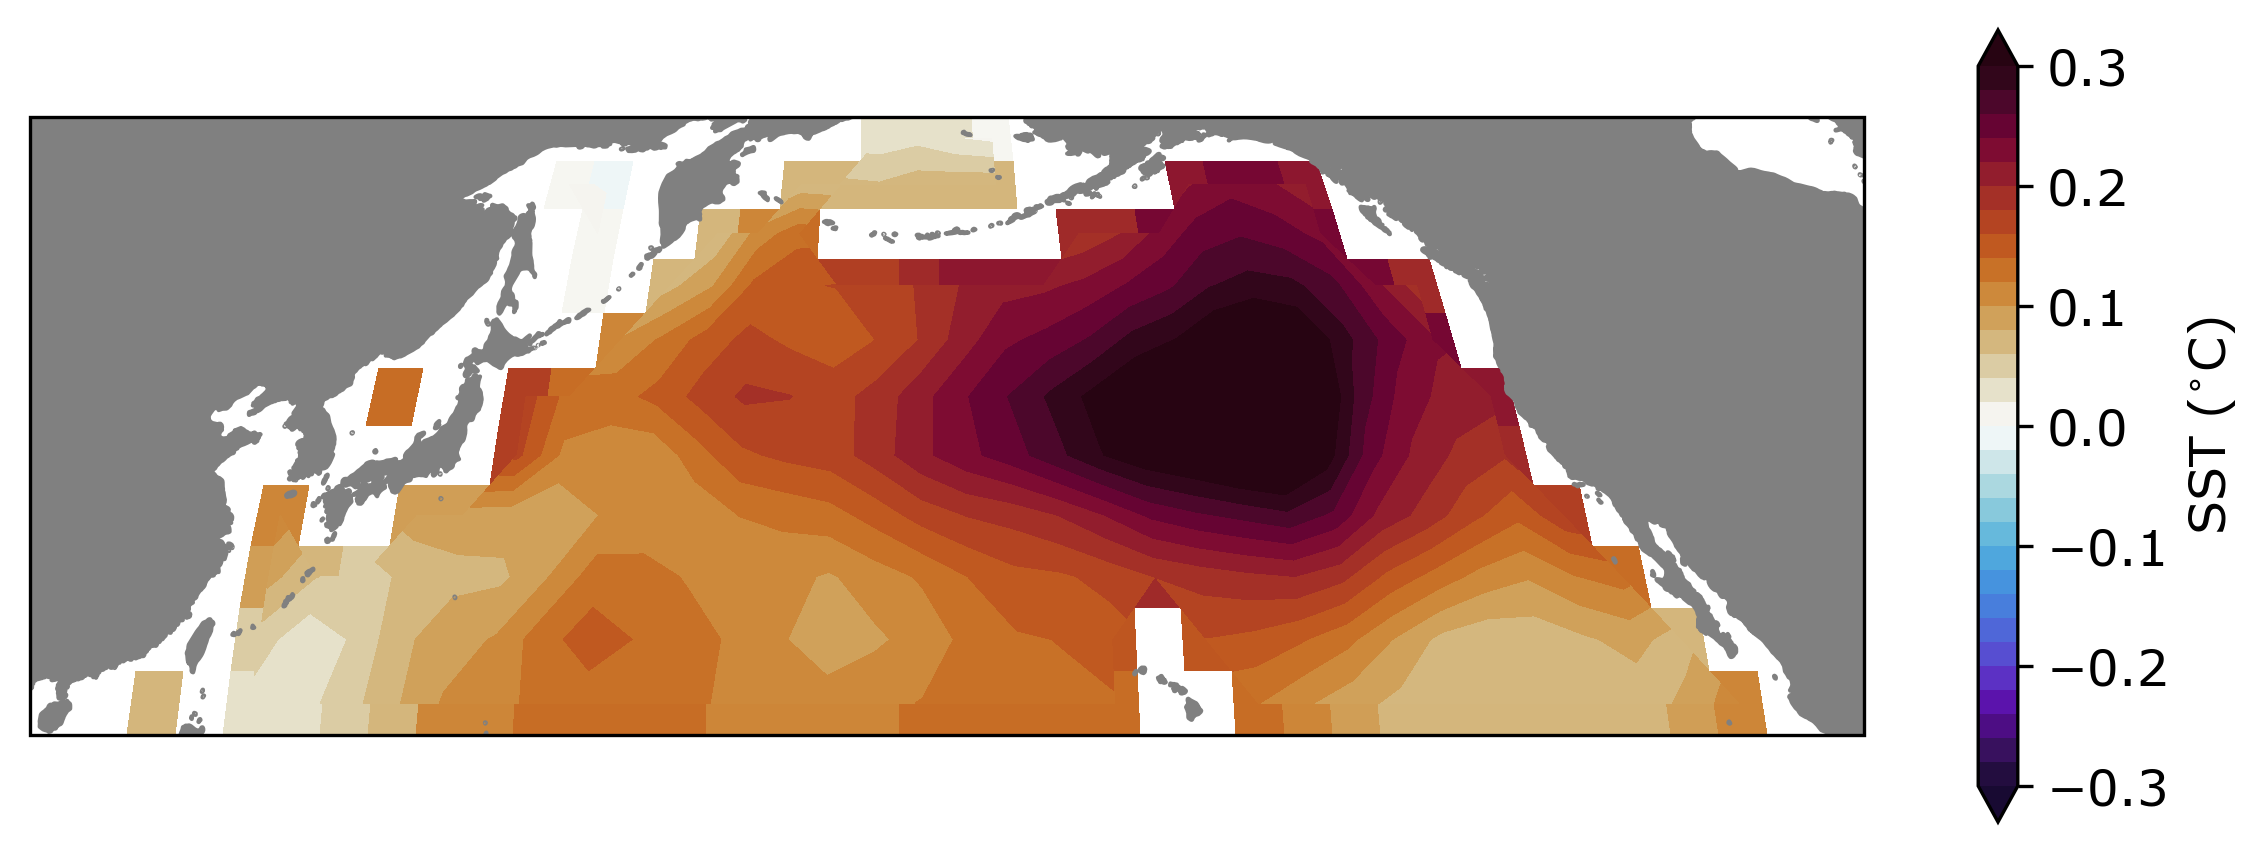

In [13]:
imp.reload(analysisplots)
analysisplots.plotpattern_SST(ERSSTpattern,lon,lat,outputstd,"ERSSTpattern")

In [56]:
imp.reload(preprocessing)

tasdomain = [20,80,100,300]

obs_ERA5 = preprocessing.makeoutputonly_obs(experiment_dict,"HadCRUT",tasdomain)

biglat = obs_ERA5.lat
biglon = obs_ERA5.lon
obstastime = obs_ERA5.year

obs_ERA5 = np.asarray(obs_ERA5)

y_pred_obs_ERAtime = y_pred_obs[-1*len(obstastime):,:,:]


/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/data/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc


In [57]:
obs_ERA5.shape

(80, 16, 50)

In [58]:
obstastime

<xarray.DataArray 'year' (year: 80)>
array([1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
Coordinates:
    realization  int64 100
  * year         (year) int64 1944 1945 1946 1947 1948 ... 2020 2021 2022 2023

In [59]:
tas_val = preprocessing.makeoutputonly_modellist_emeandetrend(experiment_dict,tasdomain,varsel="tas",validation=True)

tas
ACCESS-ESM1-5
elapsed time = 17.697069
CanESM5
elapsed time = 16.404425
CESM2
elapsed time = 8.935719
CNRM-CM6-1
elapsed time = 9.231903
IPSL-CM6A-LR
elapsed time = 9.659003
MIROC-ES2L
elapsed time = 9.061128
MIROC6
elapsed time = 16.284281
MPI-ESM1-2-LR
elapsed time = 16.268311
NorCPM1
elapsed time = 8.975816


In [60]:
tas_val = np.asarray(tas_val)
tas_val_shape = tas_val.shape

tas_val_flat = np.reshape(tas_val,(tas_val_shape[0]*tas_val_shape[1]*tas_val_shape[2],tas_val_shape[3],tas_val_shape[4]))
tas_val_flat.shape

(10728, 16, 50)

In [61]:
imp.reload(allthelinalg)

outputobs_pred,outputobs_ACC,MSSS_SC,persistence,a_TAS = allthelinalg.some_simple_models_tas(
            y_pred_obs_ERAtime,obs_ERA5,outputval,tas_val_flat,bestpattern,landmask,biglat,biglon,run)

In [62]:
obs_f = np.fft.fft(obs_ERA5,axis=0)
obs_f_auto = obs_f * np.conjugate(obs_f)

obs_auto = np.fft.ifft(obs_f_auto,axis=0)
obs_auto = np.real(obs_auto[:30]/np.max(obs_auto,axis=0))

autotime = np.argmin(np.abs(obs_auto[:7]-np.exp(-1)),axis=0)


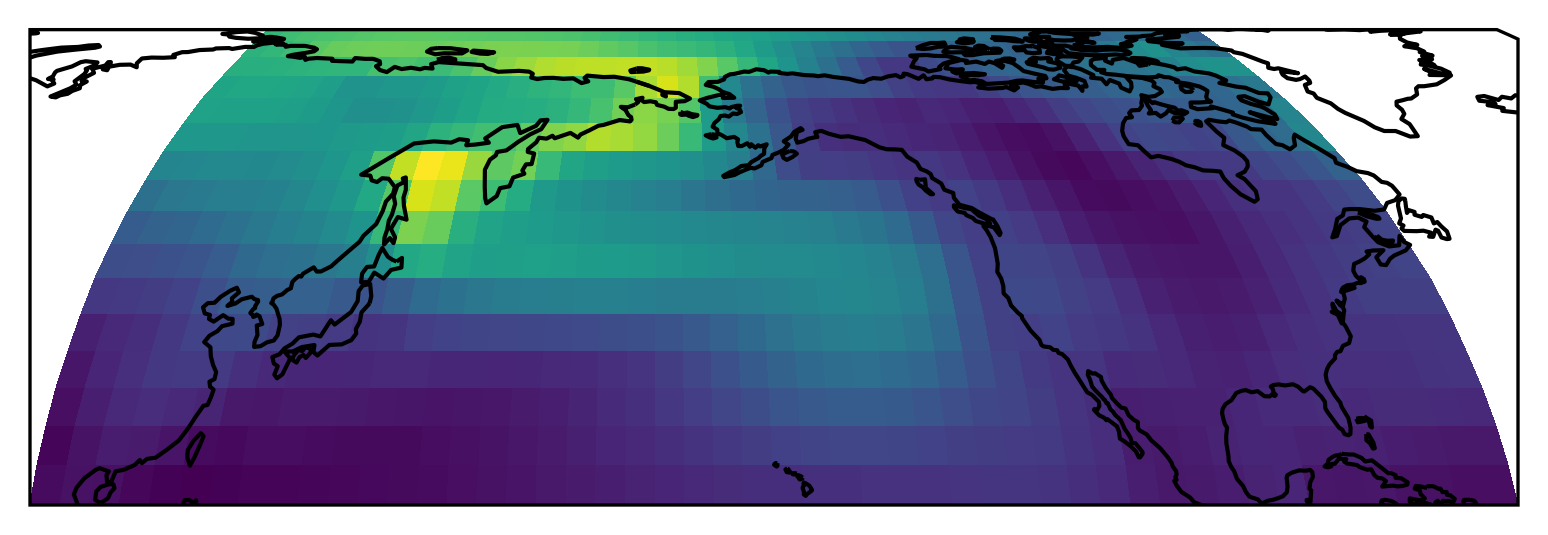

In [63]:
a1=plt.subplot(1,1,1,projection=projection)
a1.pcolormesh(biglon,biglat,a_TAS,transform=transform)
a1.coastlines()

In [64]:
nboots = 100

pearsonboots_CNNSC = np.empty((nboots,len(biglat),len(biglon)))+np.nan
pearsonboots_persistence = np.empty((nboots,len(biglat),len(biglon)))+np.nan

persistence_true = obs_ERA5[run:]
persistence_pred = obs_ERA5[:-1*run]

for ilat,_ in enumerate(biglat):
    for ilon,_ in enumerate(biglon):

        blocklength = autotime[ilat,ilon]
        if blocklength > 0:
            # print(blocklength)
            nsel = int(np.ceil(len(persistence_true)/blocklength))
            indexmatrix = np.asarray([np.arange(i,i+blocklength,dtype=int) for i in range(len(persistence_true))])

            for iboot in range(nboots):

                inds = np.random.choice(np.arange(persistence_pred.shape[0]),size=(nsel+20),replace=True)
                samps = indexmatrix[inds,:].flatten()
                samps = samps[samps<len(persistence_true)]
                samps = samps[:len(persistence_true)]

                pearsonboots_CNNSC[iboot,ilat,ilon],_ = pearsonr(outputobs_pred[samps+run,ilat,ilon],obs_ERA5[samps+run,ilat,ilon]) # account persistence containing "run" fewer predicitons
                pearsonboots_persistence[iboot,ilat,ilon],_ = pearsonr(persistence_true[samps,ilat,ilon],persistence_pred[samps,ilat,ilon])


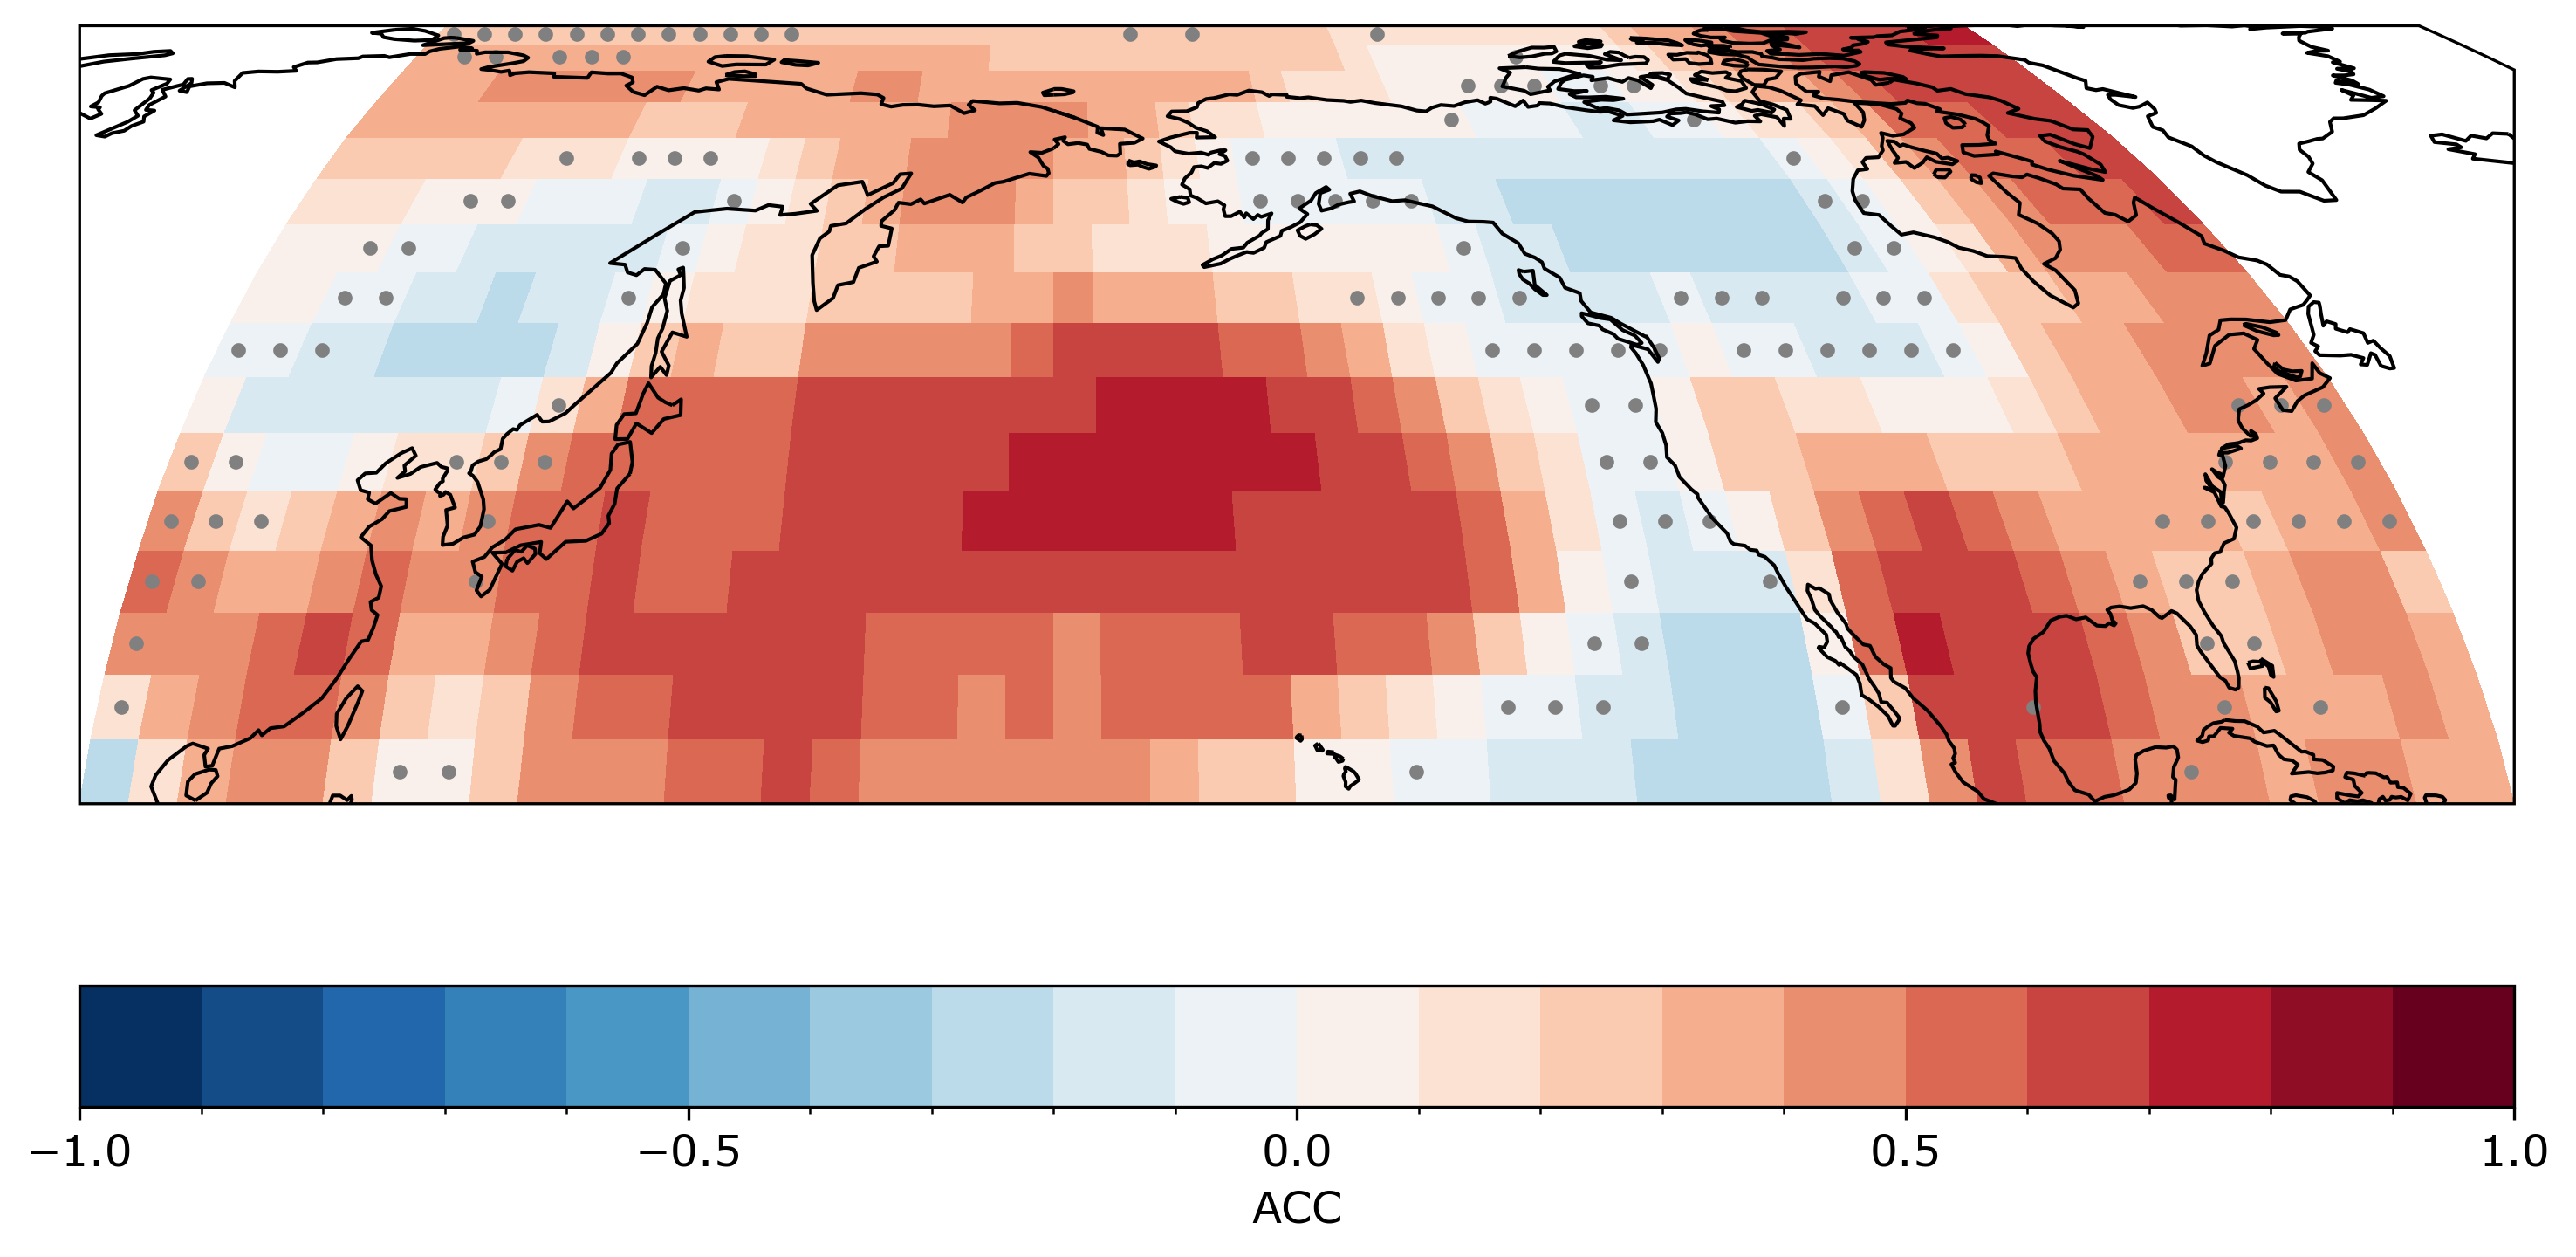

In [65]:
CNNSC_sig,CNNSC_p = ttest_ind(np.arctanh(pearsonboots_CNNSC),np.arctanh(pearsonboots_persistence),axis=0) 
CNNSC_mask =  (CNNSC_p<=0.05) & (((CNNSC_sig>0) & (outputobs_ACC>0)) | ((CNNSC_sig<0) & (outputobs_ACC<0)))

lonsig,latsig = np.meshgrid(biglon,biglat)

# lonsig[~landmask] = np.nan
# latsig[~landmask] = np.nan

lbound = -1
ubound = 1

cmapdiv = plt.get_cmap("RdBu_r")
bounds = np.arange(lbound,ubound+0.1,0.1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=cmapdiv.N)
norm2 = colors.BoundaryNorm(boundaries=np.arange(-0.4,0.45,0.05), ncolors=cmapdiv.N)

plt.figure(figsize=(12,6))

a1=plt.subplot(1,1,1,projection=ccrs.EqualEarth(central_longitude=180))
c1=a1.pcolormesh(biglon,biglat,outputobs_ACC,norm=norm,cmap=cmapdiv,transform=transform)
a1.coastlines()
# a1.set_extent([10, 200, 0, 10])
# a1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey'))
a1.scatter(lonsig[~CNNSC_mask],latsig[~CNNSC_mask],marker='.',transform=transform,color='gray')
cbar=plt.colorbar(c1,orientation='horizontal',ticks=np.arange(-1,1.5,0.5))
cbar.ax.set_xlabel("ACC")
# plt.title("d. CNN-SC")

# a2=plt.subplot(2,1,2,projection=projection)
# c2=a2.pcolormesh(biglon,biglat,MSSS_SC,norm=norm,cmap=cmapdiv,transform=transform)
# a2.coastlines()

# cax=plt.axes((0.2,0.07,0.6,0.03))
# cbar=plt.colorbar(c1,cax=cax,orientation='horizontal')
# cbar.ax.set_xlabel(r'MSSS')
# cbar.ax.set_xticks(np.arange(-1,1.2,0.2))
# plt.tight_layout()

plt.savefig("figures/ACC_global_tas.png",dpi=300)

plt.show()

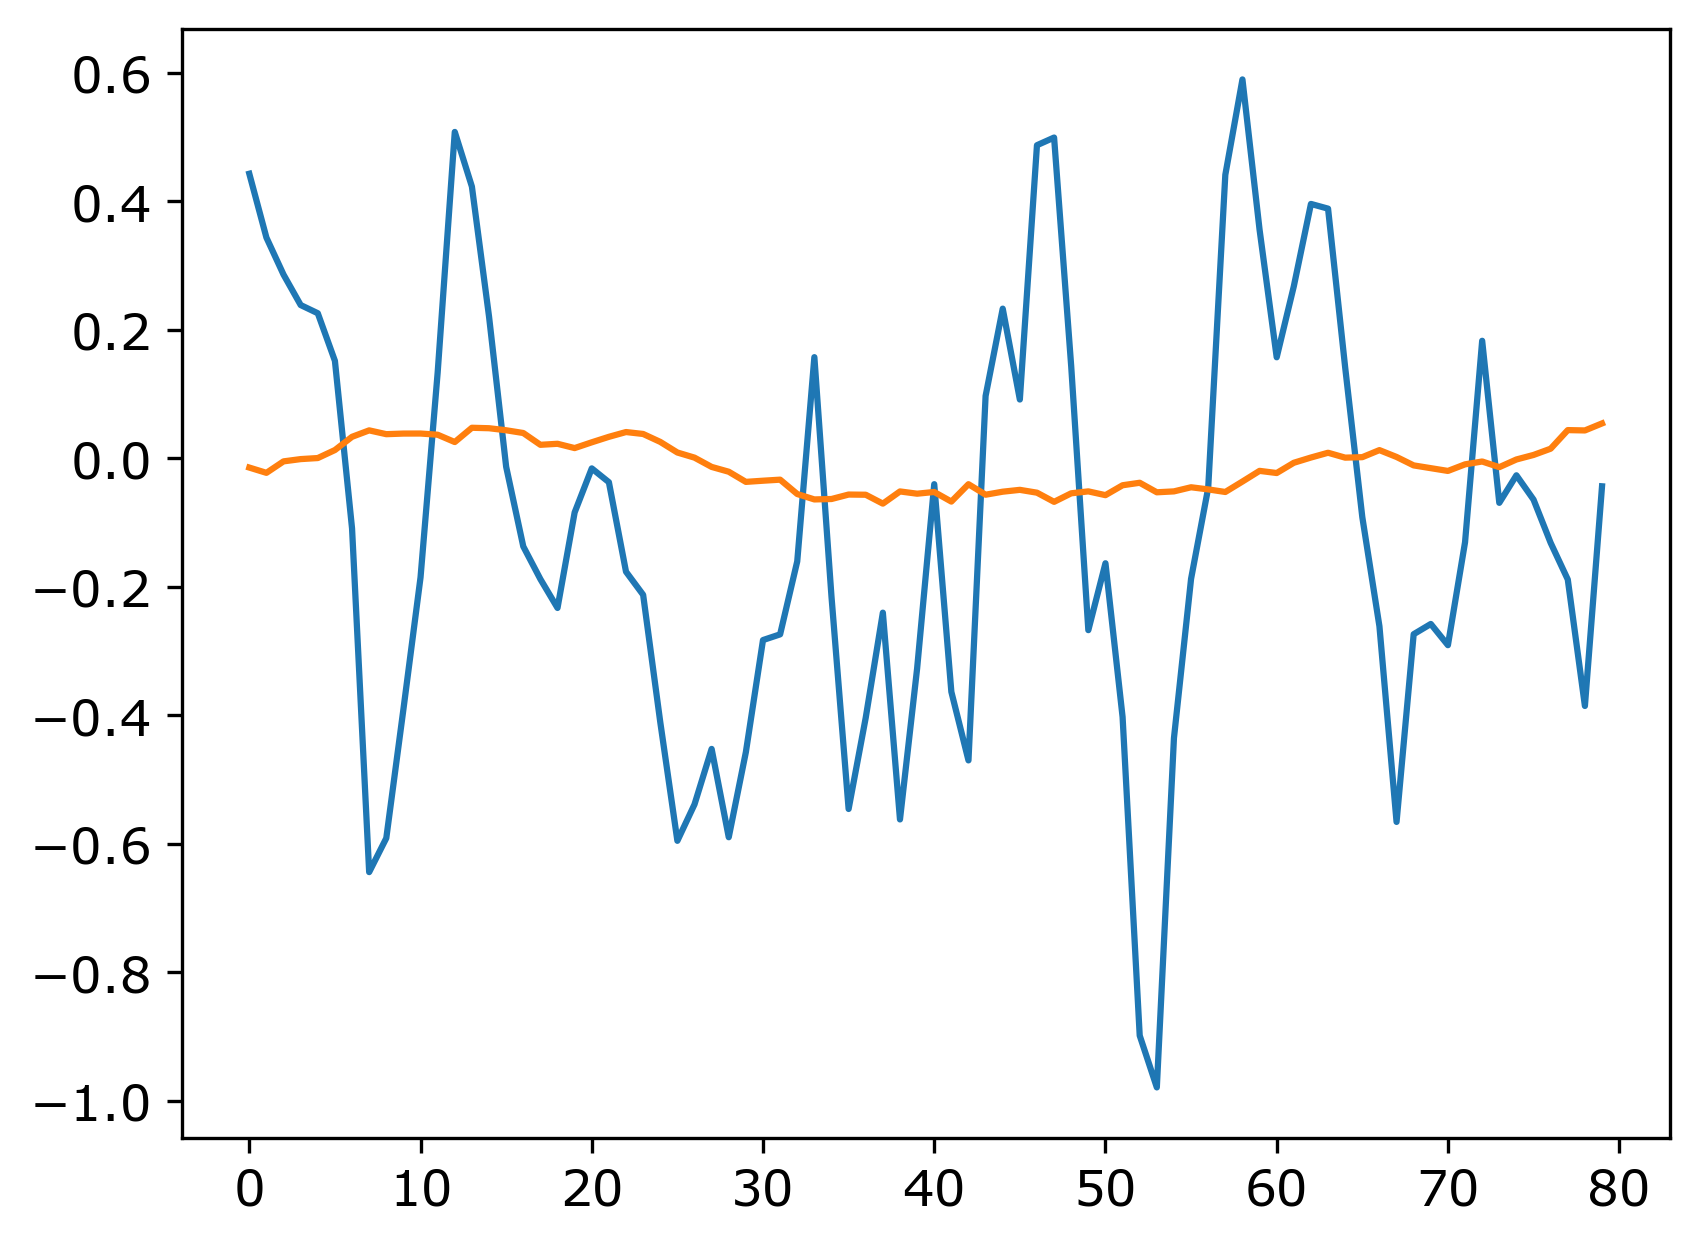

In [23]:
plt.plot(obs_ERA5[:,6,-10])
plt.plot(outputobs_pred[:,6,-10])

In [24]:
outputobs_pred.shape

(80, 11, 50)

In [25]:
# plt.plot(outputobs_pred[:,8,-10])
# plt.plot(obs_ERA5[:,8,-10])
pearsonr(obs_ERA5[:,8,25],outputobs_pred[:,8,25])

PearsonRResult(statistic=0.2451577341283807, pvalue=0.02839308522109371)

In [26]:
pearsonr(obs_ERA5[:,8,30],outputobs_pred[:,8,30])

PearsonRResult(statistic=-0.0655683117321804, pvalue=0.5633632609411151)